## Reinforcement Learning Project


    You are hired as a Sr. Machine Learning Er. at SuperCabs, a leading app-based cab provider in a large 
    Indian metro city. 
    In this highly competitive industry, retention of good cab drivers is a crucial business driver, 
    and you believe that a sound RL-based system for assisting cab drivers can potentially retain 
    and attract new cab drivers.

#### Cab-Driver Agent

###### tqdm package needs to be installed to use the Jupyter notebook widget - tqdm in para number 13

In [1]:
#installing tqdm for better visualization
!pip install tqdm

You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt
import time, os, fnmatch, shutil
from tqdm import tqdm_notebook as tqdm

# Import the environment
from Env import CabDriver

C:\Users\lenovo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Function for tracking the state-action pairs for checking convergence - Q table


In [4]:
def init_Q_table(state_size, action_size):
    Q = np.zeros([state_size, action_size])
    return Q

In [5]:
def update_Q_table(state_size, state, action, reward, nextstate,learning_rate, discount_factor):
    QA = np.max([agent.Q[(next_state,a)] for a in range(state_size)])
    Q[(state,action)] += learning_rate * (reward + discount_factor* QA - agent.Q[(state, action)])

In [6]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size,epsilon=1):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN -- experimental
        self.discount_factor = 0.95
        self.learning_rate =  0.01      
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.99995
        self.epsilon_min = 0.01
        self.epsilon = epsilon
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

        # initialize target model
        self.target_model.set_weights(self.model.get_weights())

    # approximate Q function using Neural Network
    #    self.Q = init_Q_table(self.state_size, self.action_size )
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu',kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

 #   def get_epsilon(episode):
    def track_Q_values(self,state):
        Q_val = []
        state = np.array(env.state_encod_arch1(state)).reshape(1, self.state_size)
        #Q_val = np.max(self.model.predict(state)[0])
        Q_val = self.model.predict(state)
        return Q_val
    
    def get_action(self, state,possible_actions_idx,possible_actions,episode):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment 
        
        self.epsilon *= -self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        actions_list=[]
        if np.random.rand() <= self.epsilon:
            return np.random.randint(len(possible_actions))
        state = np.array(env.state_encod_arch1(state)).reshape(1, self.state_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0]) # returns action
    

    def append_sample(self, state, action, reward, next_state):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))
        # Decay in ε after we generate each sample from the environment
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        model_loss = 0    
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size))# write here
            
            actions, rewards = [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                #Update your 'update_output' and 'update_input' batch
                update_input[i] = np.array(state).reshape(1,36)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = np.array(next_state).reshape(1,36)

                # Write your code from here
                # Predict the target from earlier model
                
                target = self.model.predict(update_input)
                target_val = self.model.predict(update_output)
                target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(target_val[i]))                
        # Fit your model and track the loss values
            Agent_model = self.model.fit(update_input, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)
            model_loss = Agent_model.history['loss'][0]
            
        return model_loss

    def save(self, name):
        self.model.save(name)

In [8]:
#Running for 2000 episodes
Episodes = 2000

**Following State and all its action will be tracked**

In [9]:
#Tracking for One State - as an exmple
tracked_Q_values= [[0,4,2]]

**To store rewards and Q value in each episode**

In [12]:
loss_per_episode, rewards_per_episode, episodes= [], [], []
Q_values = {}

### DQN block

###### tqdm package needs to be installed to use the Jupyter notebook widget - tqdm

In [13]:
for episode in tqdm(range(Episodes)):
#for episode in range(Episodes):
    # Write code here
    # Call the environment
    env = CabDriver()
    # Call all the initialised variables of the environment
    action_size = len(env.action_space)
    state = list(env.state_init)
    state_size = len(env.state_encod_arch1(state))
    #Call the DQN agent
    print("Episode NO:",episode)
    if episode == 0 :
        agent = DQNAgent(state_size, action_size)
    Reward_total = []
    Reward_Avg = 0
    Loss_total = []
    Loss_Avg = 0
    
    terminal_state = bool(0)
    while not terminal_state:
        
        # Write your code here
        start = time. time()
        # 1. Pick epsilon-greedy action from possible actions for the current state
        possible_actions_idx,possible_actions = env.requests(state)        
        action = agent.get_action(state,possible_actions_idx,possible_actions,episode)
        
        # 2. Evaluate your reward and next state
        reward = env.reward_func(state, env.action_space[action], Time_matrix)
        next_state,terminal_state = env.next_state_func(state, env.action_space[action], Time_matrix)
        
        # 3. Append the experience to the memory
        agent.append_sample(env.state_encod_arch1(state),action,reward,env.state_encod_arch1(next_state))
        
        # 4. Train the model by calling function agent.train_model
        model_loss = agent.train_model()

        # 5. Keep a track of rewards, Q-values, loss
        state = list(next_state)
        Reward_total.append(reward)
        Loss_total.append(model_loss)
        
    end = time. time()
    print('Time Taken: ', (end - start))
    
    Reward_Avg = np.mean(Reward_total)
    #print ("Avg reward: ", Reward_Avg)
    Loss_Avg = np.mean(Loss_total)
    #print ("Avg Loss: ", Loss_Avg)
    
    # store total reward obtained in this episode
    rewards_per_episode.append(Reward_Avg)
    loss_per_episode.append(Loss_Avg)
    episodes.append(episode)

    #Track all the actions for Q values for 1 states (for multiple states it can be enumerated )
    for i,q in enumerate(tracked_Q_values):
        val = agent.track_Q_values(q)
        Q_values[episode]= val
    
    # every few episodes save it:
    if episode % 10 == 0:
        # store q-values of some prespecified state-action pairs
        # q_dict = agent.store_q_values()
        agent.save(name="DQN_Model.h5")

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

Episode NO: 0
Time Taken:  0.062483787536621094
Episode NO: 1
Time Taken:  0.062485456466674805
Episode NO: 2
Time Taken:  0.062485456466674805
Episode NO: 3
Time Taken:  0.07810688018798828
Episode NO: 4
Time Taken:  0.07810544967651367
Episode NO: 5
Time Taken:  0.0624847412109375
Episode NO: 6
Time Taken:  0.07810688018798828
Episode NO: 7
Time Taken:  0.062485694885253906
Episode NO: 8
Time Taken:  0.06248664855957031
Episode NO: 9
Time Taken:  0.07810759544372559
Episode NO: 10
Time Taken:  0.07810568809509277
Episode NO: 11
Time Taken:  0.0624845027923584
Episode NO: 12
Time Taken:  0.07810664176940918
Episode NO: 13
Time Taken:  0.07810521125793457
Episode NO: 14
Time Taken:  0.062485694885253906
Episode NO: 15
Time Taken:  0.07810640335083008
Episode NO: 16
Time Taken:  0.07810664176940918
Episode NO: 17
Time Taken:  0.07810807228088379
Episode NO: 18
Time Taken:  0.07810664176940918
Episode NO: 19
Time Taken:  0.07810688018798828
Episode NO: 20
Time Taken:  0.06248402595520019

Time Taken:  0.07810640335083008
Episode NO: 337
Time Taken:  0.07810711860656738
Episode NO: 338
Time Taken:  0.07810449600219727
Episode NO: 339
Time Taken:  0.07810568809509277
Episode NO: 340
Time Taken:  0.07810664176940918
Episode NO: 341
Time Taken:  0.0879526138305664
Episode NO: 342
Time Taken:  0.08965182304382324
Episode NO: 343
Time Taken:  0.0797126293182373
Episode NO: 344
Time Taken:  0.09041118621826172
Episode NO: 345
Time Taken:  0.09937381744384766
Episode NO: 346
Time Taken:  0.08690857887268066
Episode NO: 347
Time Taken:  0.08572769165039062
Episode NO: 348
Time Taken:  0.09001016616821289
Episode NO: 349
Time Taken:  0.09020352363586426
Episode NO: 350
Time Taken:  0.08972334861755371
Episode NO: 351
Time Taken:  0.08006644248962402
Episode NO: 352
Time Taken:  0.07989120483398438
Episode NO: 353
Time Taken:  0.08001971244812012
Episode NO: 354
Time Taken:  0.09037971496582031
Episode NO: 355
Time Taken:  0.08989095687866211
Episode NO: 356
Time Taken:  0.1040425

Time Taken:  0.11354637145996094
Episode NO: 671
Time Taken:  0.10011601448059082
Episode NO: 672
Time Taken:  0.10379219055175781
Episode NO: 673
Time Taken:  0.09000229835510254
Episode NO: 674
Time Taken:  0.10008740425109863
Episode NO: 675
Time Taken:  0.09299397468566895
Episode NO: 676
Time Taken:  0.07810783386230469
Episode NO: 677
Time Taken:  0.06248664855957031
Episode NO: 678
Time Taken:  0.07810664176940918
Episode NO: 679
Time Taken:  0.07810735702514648
Episode NO: 680
Time Taken:  0.0624849796295166
Episode NO: 681
Time Taken:  0.07810735702514648
Episode NO: 682
Time Taken:  0.07810688018798828
Episode NO: 683
Time Taken:  0.07810711860656738
Episode NO: 684
Time Taken:  0.06248641014099121
Episode NO: 685
Time Taken:  0.0624849796295166
Episode NO: 686
Time Taken:  0.0624847412109375
Episode NO: 687
Time Taken:  0.062483787536621094
Episode NO: 688
Time Taken:  0.07810735702514648
Episode NO: 689
Time Taken:  0.062483787536621094
Episode NO: 690
Time Taken:  0.062485

Time Taken:  0.0624845027923584
Episode NO: 1005
Time Taken:  0.07810568809509277
Episode NO: 1006
Time Taken:  0.07810688018798828
Episode NO: 1007
Time Taken:  0.07810640335083008
Episode NO: 1008
Time Taken:  0.0624845027923584
Episode NO: 1009
Time Taken:  0.0624847412109375
Episode NO: 1010
Time Taken:  0.0624849796295166
Episode NO: 1011
Time Taken:  0.07810568809509277
Episode NO: 1012
Time Taken:  0.07810711860656738
Episode NO: 1013
Time Taken:  0.07810616493225098
Episode NO: 1014
Time Taken:  0.06248617172241211
Episode NO: 1015
Time Taken:  0.07810640335083008
Episode NO: 1016
Time Taken:  0.062485694885253906
Episode NO: 1017
Time Taken:  0.07810664176940918
Episode NO: 1018
Time Taken:  0.09372782707214355
Episode NO: 1019
Time Taken:  0.06248593330383301
Episode NO: 1020
Time Taken:  0.0781092643737793
Episode NO: 1021
Time Taken:  0.07810568809509277
Episode NO: 1022
Time Taken:  0.07810688018798828
Episode NO: 1023
Time Taken:  0.07810568809509277
Episode NO: 1024
Time

Episode NO: 1332
Time Taken:  0.07810854911804199
Episode NO: 1333
Time Taken:  0.062485456466674805
Episode NO: 1334
Time Taken:  0.062485694885253906
Episode NO: 1335
Time Taken:  0.062485456466674805
Episode NO: 1336
Time Taken:  0.0624852180480957
Episode NO: 1337
Time Taken:  0.062483787536621094
Episode NO: 1338
Time Taken:  0.07810711860656738
Episode NO: 1339
Time Taken:  0.07810592651367188
Episode NO: 1340
Time Taken:  0.0624852180480957
Episode NO: 1341
Time Taken:  0.0624845027923584
Episode NO: 1342
Time Taken:  0.07810711860656738
Episode NO: 1343
Time Taken:  0.07810640335083008
Episode NO: 1344
Time Taken:  0.062484025955200195
Episode NO: 1345
Time Taken:  0.07810640335083008
Episode NO: 1346
Time Taken:  0.07810664176940918
Episode NO: 1347
Time Taken:  0.07810664176940918
Episode NO: 1348
Time Taken:  0.06248593330383301
Episode NO: 1349
Time Taken:  0.0624852180480957
Episode NO: 1350
Time Taken:  0.07810759544372559
Episode NO: 1351
Time Taken:  0.06248617172241211

Episode NO: 1659
Time Taken:  0.07810759544372559
Episode NO: 1660
Time Taken:  0.07810640335083008
Episode NO: 1661
Time Taken:  0.062485694885253906
Episode NO: 1662
Time Taken:  0.07810664176940918
Episode NO: 1663
Time Taken:  0.062483787536621094
Episode NO: 1664
Time Taken:  0.07810711860656738
Episode NO: 1665
Time Taken:  0.07810688018798828
Episode NO: 1666
Time Taken:  0.0624852180480957
Episode NO: 1667
Time Taken:  0.0624845027923584
Episode NO: 1668
Time Taken:  0.07810544967651367
Episode NO: 1669
Time Taken:  0.07810711860656738
Episode NO: 1670
Time Taken:  0.07810616493225098
Episode NO: 1671
Time Taken:  0.06248641014099121
Episode NO: 1672
Time Taken:  0.062485694885253906
Episode NO: 1673
Time Taken:  0.09373021125793457
Episode NO: 1674
Time Taken:  0.07810711860656738
Episode NO: 1675
Time Taken:  0.0624847412109375
Episode NO: 1676
Time Taken:  0.07810711860656738
Episode NO: 1677
Time Taken:  0.062484025955200195
Episode NO: 1678
Time Taken:  0.06248378753662109

Time Taken:  0.07810711860656738
Episode NO: 1987
Time Taken:  0.07810664176940918
Episode NO: 1988
Time Taken:  0.062485694885253906
Episode NO: 1989
Time Taken:  0.07810664176940918
Episode NO: 1990
Time Taken:  0.07810616493225098
Episode NO: 1991
Time Taken:  0.07810664176940918
Episode NO: 1992
Time Taken:  0.0624852180480957
Episode NO: 1993
Time Taken:  0.07810735702514648
Episode NO: 1994
Time Taken:  0.06248593330383301
Episode NO: 1995
Time Taken:  0.0624852180480957
Episode NO: 1996
Time Taken:  0.062485456466674805
Episode NO: 1997
Time Taken:  0.07810664176940918
Episode NO: 1998
Time Taken:  0.062485456466674805
Episode NO: 1999
Time Taken:  0.07810688018798828


**Pickle the Model Weights**

In [14]:
weigh= agent.model.get_weights()

In [15]:
# save Model
save_obj(weigh, "DQN_Model_Weights")

**Pickle the Q value Dictionary**

In [16]:
# save Q dictionary for One state
save_obj(Q_values, "Q_values_dict")

## Tracking Convergence - Q value (for one sample state)

#### Tracking the Q vale for state [0,4,2] for its action

**Plotting Action index 2 - (1,4)** - Checking for covergence

In [17]:
Qbyaction = []
for i in range(Episodes):
    Qbyaction.append(list(Q_values.values())[i][0][2])

Text(0.5,0,'Episodes')

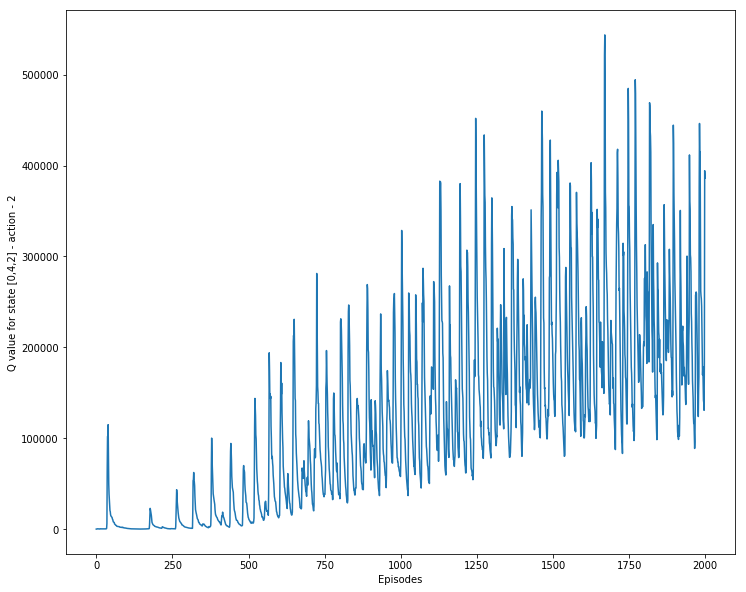

In [18]:
plt.figure(figsize=(12,10))
plt.plot(Qbyaction)
plt.ylabel("Q value for state [0,4,2] - action - 2")
plt.xlabel("Episodes")

**Plotting Action index 4 - (2,1)** - Checking for covergence

In [19]:
Qbyaction = []
for i in range(Episodes):
    Qbyaction.append(list(Q_values.values())[i][0][4])

Text(0.5,0,'Episodes')

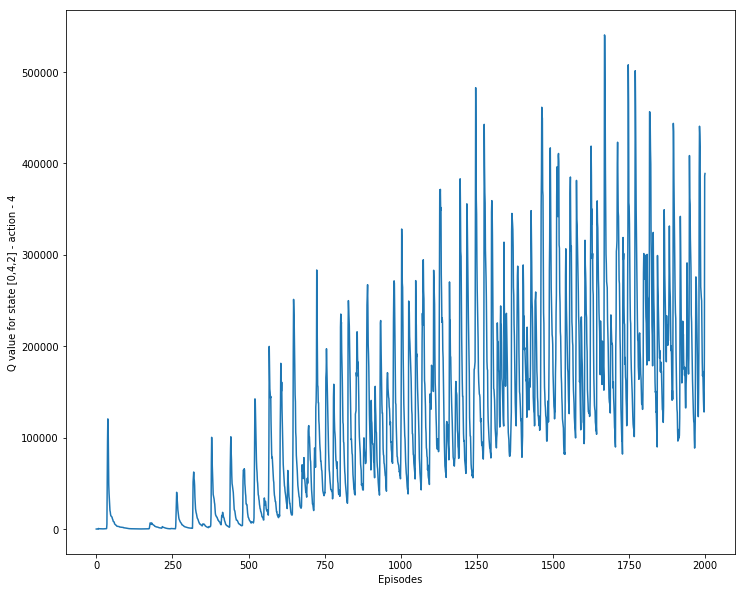

In [20]:
plt.figure(figsize=(12,10))
plt.plot(Qbyaction)
plt.ylabel("Q value for state [0,4,2] - action - 4")
plt.xlabel("Episodes")

## Tracking - Rewards by episode

In [21]:
# save rewards_per_episode
save_obj(rewards_per_episode, "rewards_per_episode")

Text(0,0.5,'Average Reward per episode')

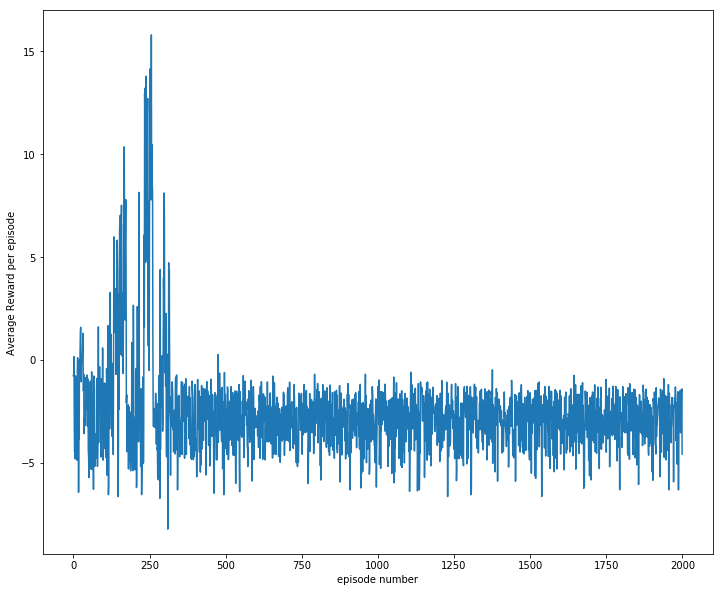

In [22]:
# plot results
with open('rewards_per_episode.pkl', 'rb') as f:
    rewards_per_episode = pickle.load(f)
plt.figure(figsize=(12,10))
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("Average Reward per episode")

## Tracking Loss by episode

In [23]:
# save rewards_per_episode
save_obj(loss_per_episode, "loss_per_episode")

Text(0,0.5,'Average Loss per episode')

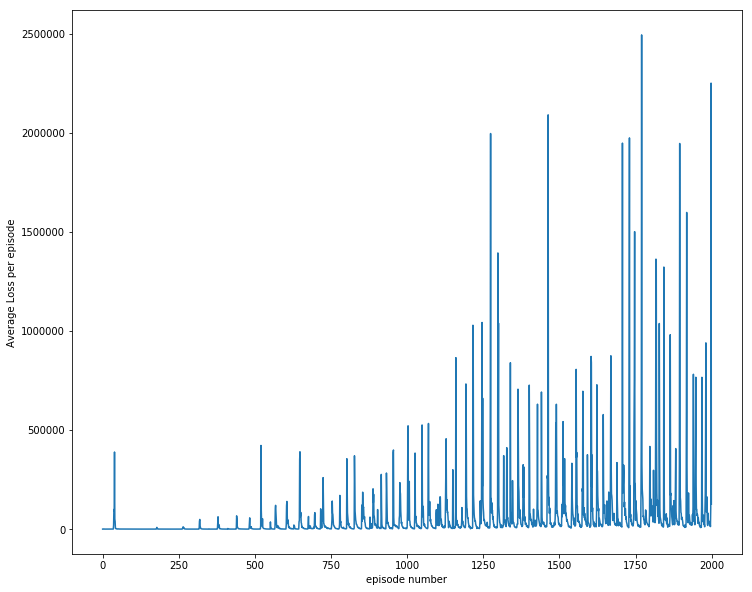

In [24]:
# plot results
with open('loss_per_episode.pkl', 'rb') as f:
    loss_per_episode = pickle.load(f)
plt.figure(figsize=(12,10))
plt.plot(list(range(len(loss_per_episode))), loss_per_episode)
plt.xlabel("episode number")
plt.ylabel("Average Loss per episode")

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [181]:
time = np.arange(0,10000)
epsilon = []

for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-agent.epsilon_decay*i))

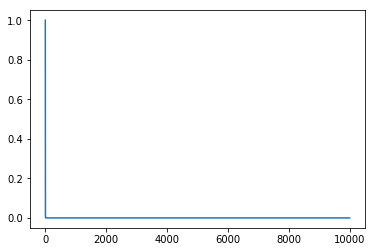

In [182]:
plt.plot(time, epsilon)
plt.show()

In [ ]:


#### Epsilon-decay sample function